# Mély generatív modellek

**Emlékeztető.** Tegyük fel, hogy a modellünkben van megfigyelt és rejtett változó is. Ez a modell illesztését nagyon megnehezíti, hiszen

\begin{align}
p(x) = \int p(x,z) dz, 
\end{align}

ahol $x$ a megfigyelt változó, $z$ rejtett. Azaz nemcsak, hogy $z$ eloszlásáról kell nyilatkoznunk (ez még menne), hanem várható értéket is kell számolni; ez az integrál azonban rendszerint nem megoldható. Szerencsére jó közelítés még így is adható. Vegyünk egy közelítő eloszlást $z$-re, és nevezzük el $q(z)$-nek. Láttuk, hogy ekkor a $p(x)$ eloszlást a következőképpen dekomponálhatjuk:

\begin{align}
\ln p(x) = \int q(z) \ln \frac{p(x,z)}{q(z)} dz - \int q(z) \ln \frac{p(z|x)}{q(z)} dz = \mathcal{L}[q] + KL(q(z)||p(z|x)) ,
\end{align}

ahol $\mathcal{L}[q]$ egy alsó korlát (ELBO) és $KL(\cdot||\cdot)$ a KL-divergencia. A varációs módszereknél olyan $q(z)$-t kerestünk, amelyik ebben a KL értelemben jól közelíti a $p(z|x)$ feltételes eloszlást; ezt úgy értük el, hogy az előbbi egyenletben az ELBO-t maximalizáltuk $q \in \mathcal{Q}$ szerint (innen a "variációs" megnevezés). Mivel a bal oldal fix, ez szükségszerűen a KL-divergencia csökkenését, azaz a közelítés javulását eredményezi. Ehhez igyekeztünk olyan $\mathcal{Q}$ függvényosztályt találni, ami elég tág ahhoz, hogy jó közelítést kapjunk (pl. mély neurális hálózatok).

**Variational autoencoder.** A feladatunk tehát az ELBO maximalizálása. A fenti formalizmust annyiban módosítjuk, hogy $q$-ba bekerül egy explicit $x$-függés is, azaz mostantól $q(z|x)$-et fogunk írni. A gyakorlatban így könnyebb jó közelítést találni; $q$-t majd egy neurális hálózat adja, $x$ lesz ennek a bemenete. Írjuk át az ELBO-t várható érték formába, és rendezzük át a tagokat:

\begin{align}
\mathcal{L}[q] &= E_{q(z|x)}\left[ \ln \frac{ p(x,z)}{q(z|x)}\right] \\
&= E_{q(z|x)}\left[\ln \frac{ p(z)}{q(z|x)} + \ln p(x|z)\right]\\
&= -KL(q(z|x)||p(z)) + E_{q(z|x)}\left[ \ln p(x|z)\right] ,
\end{align}

ahol $p(z)$-t nevezhetjük priornak. Az első tag itt némiképp hasonlít egy regularizációs taghoz ($q$ legyen "közel" a priorhoz), míg a második a már jól ismert log-likelihood függvény, amire gondolhatunk a szokásos értelemben vett veszteségfüggvényként is ("reconstruction loss"). Azaz olyan $q$ eloszlást keresünk, amely
- Eleget tesz a priornak (KL divergencia-értelemben), valamint
- Mintavételezéssel "hihető" $x$-eket generálhatunk belőle (reconstruction loss-értelemben).

Itt az ideje mindezt lefordítani a mély neurális hálózatok nyelvére. Legyen $g_\theta$ egy neurális hálózat, amelyre

\begin{align}
z = g_\theta(x,\varepsilon), \quad \varepsilon \sim p(\varepsilon)
\end{align}

Ezt nevezik "reparameterization trick"-nek; az összes véletlent az $\varepsilon$ változóba tettük, $z$ pedig ennek (és az $x$ bemenetnek) már determinisztikus függvénye. A $z$ változót gyakran nevezik látens változónak is. Az egyszerűség kedvéért legyenek $p(z)$ és $q(z|x)$ olyan eloszlások, amelyekre a KL-divergenciát könnyen ki tudjuk számolni:

\begin{align}
q(z|x) &= \mathcal{N}(z|\mu_\theta(x),\mathrm{diag}(\sigma_\theta^2(x))) ,\\
p(z) &= \mathcal{N}(z|0,I)
\end{align}

ahol a $g_\theta$ hálózat most $\mu_\theta$ és $\sigma^2_\theta$-ként szerepel (tehát valójában a hálózat egy normál eloszlás paramétereit tanulja). A KL-divergenciára vonatkozó formulát kipuskázva az ELBO tehát

\begin{align}
\frac{1}{2} \sum_j \left(1+\ln (\sigma_\theta^j(x)^2) - (\mu_\theta^j(x))^2 - (\sigma_\theta^j(x))^2 \right) + \ln p(x|z'),
\end{align}

ahol $j$ a vektor elemeit indexeli; a reconstruction loss-ban lévő várható értéket pedig egyetlen mintával közelítjük:

\begin{align}
z' = \mu_\theta(x) + \sigma_\theta(x) \odot \varepsilon, \quad \varepsilon \sim p(\varepsilon),
\end{align}

ahol $\odot$ elemenkénti szorzást jelent. A teendők tehát a következők:

- Egy neurális hálózat létrehozása, amely az $x$ bemenetek alapján a $\mu$ és $\sigma$ paramétereket tanulja, illetve vesz egy mintát ebből az eloszlásból (előző egyenlet),
- A kombinált veszteségfüggvény optimalizációja (előző előtti egyenlet).

Az architektúra a következőképpen ábrázolható (célszerű a rekonstrukciót is egy neurális hálózattal megoldani):

![](https://cdn-images-1.medium.com/max/2600/1*22cSCfmktNIwH5m__u2ffA.png)

**Adversarial autoencoder.** Felmerül a kérdés, hogy mi a teendő, ha olyan eloszlást válaszunk $q(z|x)$-nek, amelyre a KL-divergenciát nem tudjuk kiszámolni. Ekkor megtehetjük, hogy a 

\begin{align}
\mathcal{L}[q] &= E_{q(z|x)}\left[\ln \frac{p(z)}{q(z|x)} + \ln p(x|z)\right]
\end{align}

kifejezésben a $\frac{p(z)}{q(z|x)}$ tagot egy szigmoid kimenetű neurális hálózattal közelítjük. Ezt nevezzük diszkriminátornak, hiszen valójában tényleg azt probálja meg eldönteni, hogy egy $z$ vajon a $p(z)$ priorból vagy a $q(z|x)$ variációs eloszlásból jön. Jelölje a diszkriminátort $\sigma(D(x,z))$, és vegyük a következő veszteségfüggvényt:

\begin{align}
E_{p(z)}\left[\ln \sigma(D(x,z)) \right] + E_{q(z|x)}\left[\ln (1-\sigma(D(x,z))) \right],
\end{align}

ami nem más, mint egy keresztentrópia álruhában, elbújtatva egy integrálba; a pénzfeldobós feladatnál kiszámoltuk, hogy a

\begin{align}
p \ln \sigma + q \ln (1-\sigma),
\end{align}

eredeti alakjában (exponenciálist véve)

\begin{align}
\sigma^p (1-\sigma)^q
\end{align}

mennyiség maximuma

\begin{align}
\sigma^* = \frac{p}{p+q},
\end{align}

ahonnan a szigmoid függvény képletét felhasználva

\begin{align}
\sigma^* = \frac{1}{1+e^{-D^*}} = \frac{p}{p+q} \quad\Rightarrow\quad D^* = \ln \frac{p}{q}, 
\end{align}

azaz a veszteségfüggvényt optimalizáló $D^*$ tényleg használható az ELBO közelítésére.

## Feladatok

A gyakorlaton MNIST képekre fogunk generatív modelleket építeni.

**Variational autoencoder**

- Hozza létre az encoder hálózatot, amelynek bemenete a kép, kimenete a látens változóból vett minta! Azaz a hálózat tanulja a látens eloszlás paramétereit, majd vegyen egy mintát a fenti formulák felhasználásával. A hálózat architektúrája tetszőleges, ám célszerű konvolúciós rétegeket is használni.
- Hozza létre a decoder hálózatot, amelynek bemenete a látens változó, kimenete pedig a rekonstruált kép!
- Implementálja a KL-divergenciát és reconstruction loss-t tartalmazó veszteségfüggvényt, majd tanítsa a hálózatot!
- Generáljon képeket oly módon, hogy a modellnek csak a generatív oldalát használja, a látens eloszlásból vett mintákra, mint bemenetre! Sikeres volt a tanítás, számjegyek jelennek meg a kimeneten?
- Vizsgálja meg a rekonstrukciókat a teszthalmazból véletlenszerűen választott minták segítségével (a teljes hálózat mennyire tudja rekonstruálni ezeket a mintákat)!
- Vizsgálja meg a látens reprezentációkat. Klasztereződnek ezek aszerint, hogy a bemenet milyen számot ábrázol?

**HF**

- Variálja a gyakorlaton összerakott architektúrát úgy, hogy javuljon a rekonstrukció és a generált minták minősége!

**Szorgalmi -- Adversarial autoencoder**

- Az előbbi modellt egészítse ki egy diszkriminátor hálózattal, amelynek bemenete a látens változó (vagy ugyanilyen dimenzionalitású véletlen zaj), kimenete pedig egyetlen skalár!
- Hozza létre a kombinált hálózatot, amely az említett arány becslésére a diszkriminátor hálózatot használja!
- Hozza létre a veszteségfüggvényeket, majd tanítsa a modellt! (felváltva a diszkriminátort és a kombinált modellt)
- Ismételje meg a generatív és rekonstrukciós teljesítmény vizsgálatát az előbbihez hasonló módon.

In [28]:
%pylab inline

import torch
from torchvision import datasets
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [70]:
train = datasets.MNIST('./data',train=True,download=True)
test  = datasets.MNIST('./data',train=False,download=True)
x     = train.data
x_cl  = train.targets
x_t   = test.data
x_tcl = test.targets

# Előfeldolgozás (nem muszáj így):
x    = ((x-127.5)/127.5).view(-1,1,28,28)
x_t  = ((x_t-127.5)/127.5).view(-1,1,28,28)

dataset = torch.utils.data.TensorDataset(x,x_cl)
loader  = torch.utils.data.DataLoader(dataset,batch_size=16,shuffle=True)

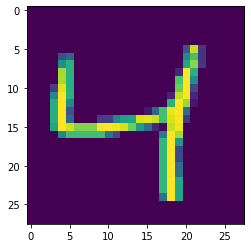

In [71]:
imshow(x[2].view(28,28))

In [72]:
class VAE(torch.nn.Module):
  def __init__(self,L):
    super(VAE, self).__init__()

    self.L = L

    self.enc = torch.nn.Sequential(
        torch.nn.Conv2d(1,32,4,2,1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(32,32,4,2,1),
        torch.nn.ReLU(),
        torch.nn.Flatten()
    )

    self.mu = torch.nn.Linear(1568,L)
    self.lv = torch.nn.Linear(1568,L)
    self.d  = torch.nn.Linear(L,1568)

    self.dec = torch.nn.Sequential(
        torch.nn.ConvTranspose2d(32,32,4,2,1),
        torch.nn.ReLU(),
        torch.nn.ConvTranspose2d(32,1,4,2,1),
        torch.nn.Tanh()
    )

  def encode(self,x):
    h = self.enc(x)
    return self.mu(h),self.lv(h)

  def decode(self,z):
    return self.dec(self.d(z).view(-1,32,7,7))

  def forward(self,x):
    mu,lv = self.encode(x)
    z = torch.randn_like(lv)*torch.exp(lv) + mu
    return self.decode(z),mu,lv, z #klaszterezés vizsgálatához látens-t is return-be

In [73]:
vae = VAE(2).cuda()

In [74]:
vae.train()
opt = torch.optim.Adam(vae.parameters())

num_epochs = 10
for epoch in range(num_epochs):
  for (i,(x_,x_cl_)) in enumerate(loader):
    opt.zero_grad()
    x_c = x_.cuda()
    rec,mu,lv, _ = vae(x_c)

    loss = torch.sum((rec-x_c)**2) - 0.5*torch.sum(1+lv-mu**2-torch.exp(lv))
    loss.backward()
    opt.step()

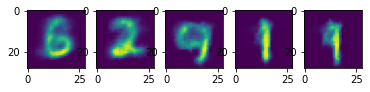

In [78]:
vae.eval()
with torch.no_grad():
  z   = torch.randn(5,2)
  gen = vae.decode(z.cuda()).cpu()

  f,ax = subplots(1,5)
  for i in range(5):
    ax[i].imshow(gen[i].view(28,28))

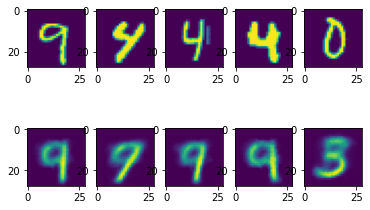

In [77]:
vae.eval()
with torch.no_grad():
  ind = np.random.choice(range(x.shape[0]),5)
  gen = vae(x[ind].cuda())[0].cpu()

  f,ax = subplots(2,5)
  for i in range(5):
    ax[0,i].imshow(x[ind[i]].view(28,28))
    ax[1,i].imshow(gen[i].view(28,28))

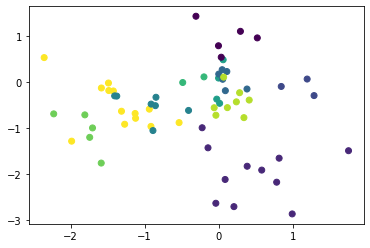

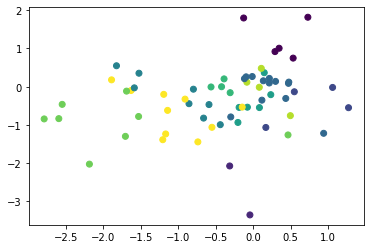

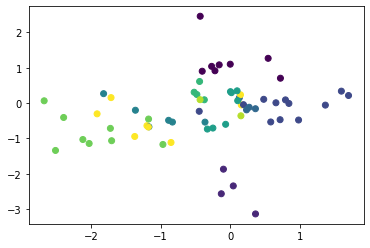

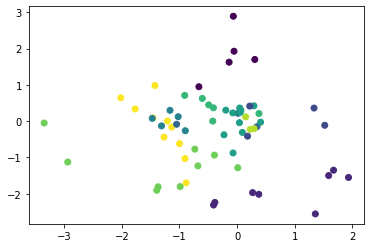

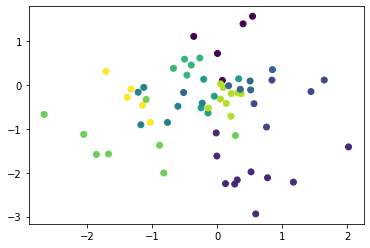

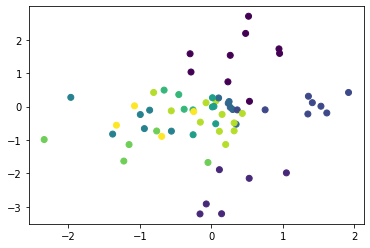

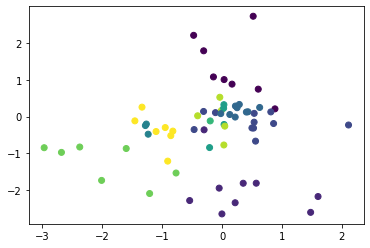

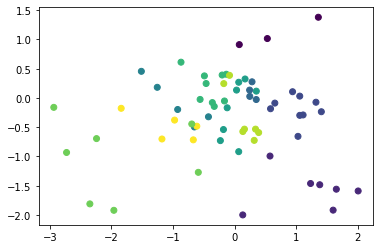

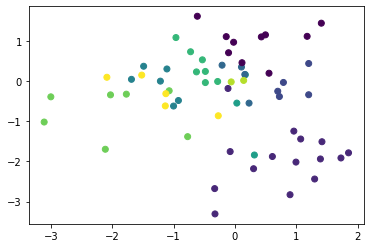

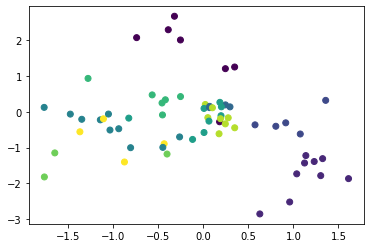

In [48]:
vae.eval()
# Látens reprezentációk plottolása
for (i,(x_,x_cl_)) in enumerate(loader):
  if i < 10:
    x_c = x_.cuda()
    rec, mu, lv, z = vae(x_c)
    plt.figure()
    plt.scatter(z.cpu().detach().numpy()[:,0], z.cpu().detach().numpy()[:,1], c=x_cl_)
    plt.show()


A fentebbi plotokból a klaszterezés egyértelmű (magasabb batch size mellett legalább is): az eredeti képosztályokkal színezve a látens reprezentációk (a gyakorlaton is elhangzottak szerint) szám szerinti klaszterekbe szerveződnek.

Az architektúrán piszkáltam:
- a generált és rekonstruált képek minősége közt fordított arányosságot találtam (legalábbis a próbálkozásaim során), ha az egyik javult, a másik romlott. Ez alól kivétel a szélsőséges eset, pl. batch size = 40000 esetén a tanulás nem a helyes veszteségfüggvény mentén tanul és felismerhetetlen lesz mindkettő. Ezzel analóg, a kis batch size túlságosan a 9-es formára fokuszálta pl a rekonstrukciót, ahogy ez a jelen helyzetben fentebb látható.